2025-03-20 12:51:29.719243: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 12:51:29.757590: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 12:51:29.757610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 12:51:29.757634: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 12:51:29.765812: I tensorflow/core/platform/cpu_feature_g

Epoch 1/100, Train Loss: 1.1466
Epoch 1/100, Val Loss: 0.9363
Best model saved.
Epoch 2/100, Train Loss: 0.8777
Epoch 2/100, Val Loss: 0.7818
Best model saved.
Epoch 3/100, Train Loss: 0.6632
Epoch 3/100, Val Loss: 0.5252
Best model saved.
Epoch 4/100, Train Loss: 0.4933
Epoch 4/100, Val Loss: 0.3769
Best model saved.
Epoch 5/100, Train Loss: 0.3698
Epoch 5/100, Val Loss: 0.2768
Best model saved.
Epoch 6/100, Train Loss: 0.2786
Epoch 6/100, Val Loss: 0.2032
Best model saved.
Epoch 7/100, Train Loss: 0.2094
Epoch 7/100, Val Loss: 0.1473
Best model saved.
Epoch 8/100, Train Loss: 0.1613
Epoch 8/100, Val Loss: 0.1167
Best model saved.
Epoch 9/100, Train Loss: 0.1308
Epoch 9/100, Val Loss: 0.0990
Best model saved.
Epoch 10/100, Train Loss: 0.1118
Epoch 10/100, Val Loss: 0.0842
Best model saved.
Epoch 11/100, Train Loss: 0.0953
Epoch 11/100, Val Loss: 0.0771
Best model saved.
Epoch 12/100, Train Loss: 0.0835
Epoch 12/100, Val Loss: 0.0665
Best model saved.
Epoch 13/100, Train Loss: 0.0738
E

/tmp/ipykernel_238/1492244038.py:168: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  processed_preds_tensor = torch.tensor(processed_preds).to(device)
/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


Dice Score: 0.8141
Hausdorff Distance: 6.4949
Pixel Accuracy: 0.9941


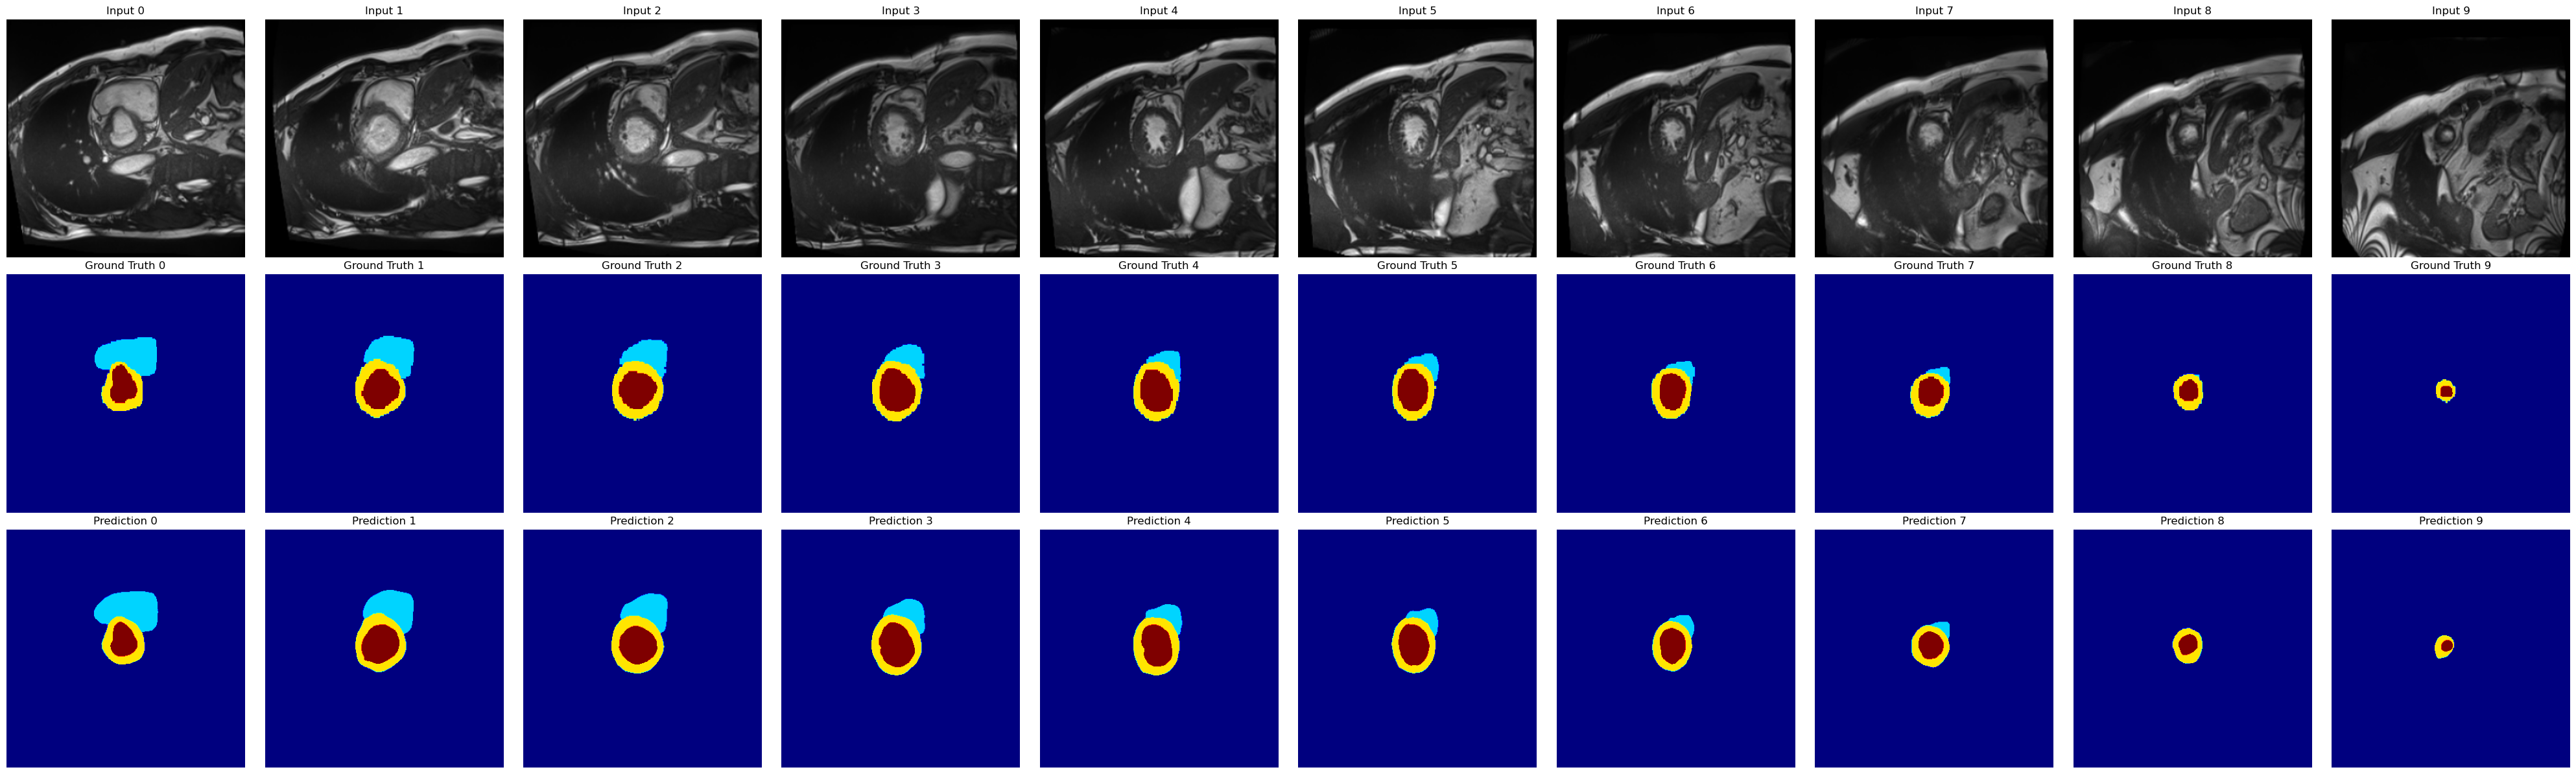

Dice Score,▁
Hausdorff Distance,▁
Pixel Accuracy,▁
train_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dice Score,0.81411
Hausdorff Distance,6.49485
Pixel Accuracy,0.99409
train_loss,0.01464
val_loss,0.02609


In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.ndimage import label
from monai.networks.nets import UNet
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ToTensord, ResizeD
from monai.metrics import DiceMetric, HausdorffDistanceMetric
import wandb

# Initialize Weights & Biases
wandb.init(project="ACDC", entity="razvan-stanciu98-university-of-twente", name="2DUnet_no_augmentation_fold_1")

# Define paths for training and validation data
data_dirs = {
    "train": [
        "./dataset/folds_slices/fold_0_slices",
        "./dataset/folds_slices/fold_2_slices",
        "./dataset/folds_slices/fold_3_slices",
        "./dataset/folds_slices/fold_4_slices",
    ],
    "val": "./dataset/folds_slices/fold_1_slices",
}

def load_dataset(data_dirs):
    data = []
    for data_dir in data_dirs:
        for patient in os.listdir(data_dir):
            patient_path = os.path.join(data_dir, patient)
            if os.path.isdir(patient_path):
                for file in os.listdir(patient_path):
                    if file.endswith('.nii') and '_gt' not in file:
                        image_path = os.path.join(patient_path, file)
                        gt_file = file.replace('_slice', '_gt_slice')
                        gt_path = os.path.join(patient_path, gt_file)
                        if os.path.exists(gt_path):
                            data.append({"image": image_path, "label": gt_path})
    return data

# Load datasets for training and validation
train_data = load_dataset(data_dirs["train"])
val_data = load_dataset([data_dirs["val"]])  # Wrap in a list for consistency

# Define transforms
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(352, 352)),
    ToTensord(keys=["image", "label"]),
])

# Create datasets and dataloaders
train_dataset = Dataset(data=train_data, transform=transforms)
val_dataset = Dataset(data=val_data, transform=transforms)

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=pad_list_data_collate),
    "val": DataLoader(val_dataset, batch_size=10, shuffle=False, collate_fn=pad_list_data_collate),
}

# Log model architecture
model = UNet(
    spatial_dims=2, in_channels=1, out_channels=4,
    channels=(64, 128, 256, 512, 1024, 2048),
    strides=(2, 2, 2, 2, 2),
    num_res_units=3, norm="batch", dropout=0.2
)

# Log the model architecture to WandB
wandb.watch(model, log="all")  # Log gradients and model parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
class_weights = torch.tensor([0.2, 0.3, 0.3, 0.2], device=device, dtype=torch.float)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

def keep_largest_component(pred_mask, min_size=50):
    output = np.zeros_like(pred_mask)
    for cls in np.unique(pred_mask):
        if cls == 0:
            continue
        binary_mask = (pred_mask == cls).astype(np.int32)
        labeled_array, num_features = label(binary_mask)
        if num_features == 0:
            continue
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0
        largest_label = sizes.argmax()
        if sizes[largest_label] >= min_size:
            largest_component = (labeled_array == largest_label)
            output[largest_component] = cls
    return output

# Training loop
num_epochs = 100
losses = {"train": [], "val": []}
best_val_loss = float('inf')
no_improvement_epochs = 0
patience = 5  # Stop if no improvement after 5 epochs

for epoch in range(num_epochs):
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        with torch.set_grad_enabled(phase == "train"):
            for batch_data in dataloaders[phase]:
                inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device).squeeze(1).long()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloaders[phase])
        losses[phase].append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, {phase.capitalize()} Loss: {epoch_loss:.4f}")

        # Log the loss to WandB
        wandb.log({f"{phase}_loss": epoch_loss})

        if phase == "val":
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), '2DUnet_no_augmentation_fold_1_1903.pth')
                wandb.save('2DUnet_no_augmentation_fold_1_1903.pth')  # Save model to WandB
                print("Best model saved.")
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
                if no_improvement_epochs >= patience:
                    print("Early stopping triggered.")
                    break
    
    scheduler.step(losses["val"][-1])
    if no_improvement_epochs >= patience:
        break

# Load best model and evaluate
model.load_state_dict(torch.load('2DUnet_no_augmentation_fold_1_1903.pth'))
model.eval()
dice_metric, hd_metric = DiceMetric(include_background=True, reduction="mean"), HausdorffDistanceMetric(include_background=True, percentile=95)

total_correct, total_pixels = 0, 0
with torch.no_grad():
    for val_batch in dataloaders["val"]:
        val_inputs, val_labels = val_batch["image"].to(device), val_batch["label"].to(device)
        val_outputs = model(val_inputs)
        preds_batch = torch.argmax(val_outputs, dim=1, keepdim=True)
        
        # Apply post-processing: Keep the largest connected component
        processed_preds = [keep_largest_component(pred.cpu().numpy(), min_size=50) for pred in preds_batch]
        
        # Convert processed predictions back to tensor for metric calculation
        processed_preds_tensor = torch.tensor(processed_preds).to(device)
        
        # Calculate performance metrics after postprocessing
        dice_metric(y_pred=processed_preds_tensor, y=val_labels)
        hd_metric(y_pred=processed_preds_tensor, y=val_labels)
        
        total_correct += (processed_preds_tensor == val_labels).sum().item()
        total_pixels += torch.numel(val_labels)

dice_score = dice_metric.aggregate().item()
hd_score = hd_metric.aggregate().item()
accuracy = total_correct / total_pixels

# Log metrics to WandB
wandb.log({
    "Dice Score": dice_score,
    "Hausdorff Distance": hd_score,
    "Pixel Accuracy": accuracy
})

print(f"Dice Score: {dice_score:.4f}")
print(f"Hausdorff Distance: {hd_score:.4f}")
print(f"Pixel Accuracy: {accuracy:.4f}")

# Visualize 25 predictions on a validation batch
with torch.no_grad():
    batch = next(iter(dataloaders["val"]))
    inputs = batch["image"].to(device)
    labels = batch["label"].to(device)
    outputs = model(inputs)

    # Get the predicted segmentation as the argmax over the channel dimension
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

    # Apply post-processing: Keep the largest connected component
    processed_preds = [keep_largest_component(pred, min_size=50) for pred in preds]

# Move inputs and labels to CPU for visualization
inputs = inputs.cpu().numpy()   # shape: (B, 1, H, W)
labels = labels.cpu().numpy()   # shape: (B, 1, H, W)

# Number of samples to display (max 25)
num_to_show = min(25, inputs.shape[0])
fig, axs = plt.subplots(3, num_to_show, figsize=(4 * num_to_show, 12))

for i in range(num_to_show):
    # Input image
    axs[0, i].imshow(inputs[i, 0, :, :], cmap="gray")
    axs[0, i].set_title(f"Input {i}")
    axs[0, i].axis("off")

    # Ground truth
    axs[1, i].imshow(labels[i, 0, :, :], cmap="jet")
    axs[1, i].set_title(f"Ground Truth {i}")
    axs[1, i].axis("off")

    # Prediction (after applying keep_largest_component)
    axs[2, i].imshow(processed_preds[i], cmap="jet")
    axs[2, i].set_title(f"Prediction {i}")
    axs[2, i].axis("off")

plt.tight_layout()
plt.show()

# Finish the WandB run
wandb.finish()

In [ ]:
# Disclaimer:
# This code has been developed with assistance from ChatGPT to support functionality and error handling.
# The authors take full responsibility for its content, functionality, and any outcomes resulting from its use.